In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors

In [101]:
def get_csv(timestamp, metric):
    return pd.read_csv(f'../../dontgitme/{timestamp}/{metric}.csv')

In [102]:
df_rate = get_csv(1587889917228, 'ops-sent-all')
df_rate

,t,count,mean_rate,m1_rate,m5_rate,m15_rate,rate_unit
0,1587889919,99,104.250203,0.000000,0.000000,0.000000,events/second
1,1587889920,215,110.319550,0.000000,0.000000,0.000000,events/second
2,1587889921,331,112.380810,0.000000,0.000000,0.000000,events/second
3,1587889922,442,111.335420,0.000000,0.000000,0.000000,events/second
4,1587889923,539,108.998418,0.000000,0.000000,0.000000,events/second
...,...,...,...,...,...,...,...
93,1587890012,8825,93.939214,85.973287,103.649659,106.946894,events/second
94,1587890013,8959,94.361113,85.973287,103.649659,106.946894,events/second
95,1587890014,9098,94.826381,89.957211,104.181057,107.106745,events/second
96,1587890015,9234,95.250193,89.957211,104.181057,107.106745,events/second


In [103]:
get_csv(1587889917228, 'polyglotAPI.controlledRate')

,t,value
0,1587889919,130
1,1587889920,130
2,1587889921,130
3,1587889922,130
4,1587889923,130
...,...,...
93,1587890012,140
94,1587890013,140
95,1587890014,140
96,1587890015,140


In [104]:
df_rate['count'][1:].values - df_rate['count'][:-1].values

array([116, 116, 111,  97, 114, 125, 126, 115, 111, 125, 123, 123, 119,
       111, 124, 129, 127, 128, 115, 127, 127, 128, 124, 112, 126, 128,
       128, 125, 123, 129, 127, 128, 126, 123, 126, 128, 129, 125, 120,
       128, 128, 128, 123, 119, 129, 128, 129, 127, 114, 125, 130, 129,
       122, 119, 128, 128, 127, 127, 122,   7,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  94, 127, 137, 138, 139, 138, 127, 139, 138,
       139, 129, 134, 139, 136, 139])

## Folders

* `1587892060198` : sdRequestNoSession 10 to 100; with log turned on; 2 mins each rate
* `1587893442020` : concurReads 10 to 100; with log turned on; 2 mins each rate (same conditions as above) BUT: there was some sort of a pause in the load faker (GC or smth) and there is a misleading drop in response times BUT it is also present above. I made a screenshot `Screenshot from 2020-04-26 12-53-37.png`
* `1587896166332` : same as those above  
  
  
* `1587916396441` : sdRequestNoSession 10 to 110; without log; 5 mins each rate
* `1587924832446` : more or less okay for sdRequestSeparateSession
* `1587929144235` : sdRequestSeparateSession good 10 to 110; without log; 5 mins each rate  
  
  
* `1587992568036` : simpleOlep 10 to 110-120; without log; 2 mins each rate. I might have added some deletion requests; also I changed the getUnreads to getTotalCounts. PS I think it's bad because Lucene was incredibly slow to post and delete stuff strangely slower than the next test of serReads
* `1587994895842` : Better simpleOlep: 10 to 110-120 without log 2 mins each rate; Lucene is very slow to post stuff and this causes the messages in the log to pile up (only deletions in this case). But this does not stop reads like searching, which still has low turnaround time
* `1588086690771` : ser_reads 10 to 100 without log 2 mins each rate. There was some fall at the end of the 100 rate probably because of Java GC.  
  
    
* `1588510006021` : sdRequestSeparateSession 2 mins without log looked good
* `1588520606558` : sdRequestNoSession 2 mins without log looked good though the end of 110 got a bit bad
* `1588522191956` : concurReads 2 mins without log looked good same thing
  
* `1588524756412` : serReads 2 mins without log looked alright and bad at the 110 end
* `1588527019868` : simpleOlep 2 mins without log until fucking 200 boy


In [105]:
def get_color(idx, alpha):
    h = list(mcolors.TABLEAU_COLORS.values())[idx][1:]
    rgb = [int(h[i:i+2], 16) / 256 for i in (0, 2, 4)]
    
    return tuple(rgb + [alpha])

In [106]:
def magic(timestamps, names, saveto=None, request_name='psql.RequestPostMessage', 
          request_display='Post message'):
    ofs = 50
    base_alpha = 0.4
    
    rates = [get_csv(timestamp, 'polyglotAPI.controlledRate') for timestamp in timestamps]
    posts = [get_csv(timestamp, f'favours.{request_name}.hist') for timestamp in timestamps]
    
    size = len(timestamps)
    rate_step = 10
    block_width = 7
    each_width = block_width / size
    
    rates_to_use = range(10, 111, 10)
    
    for rate, post, name, i in zip(rates, posts, names, range(size)):
        minlength = min(len(post), len(rate))
        rate = rate.iloc[:minlength]
        post = post.iloc[:minlength]
        
        aggregate = []
        aggregate_stddev = []
        bins = []
        for r in rates_to_use:
            idx = (rate['value'] == r)

            mean_times = post['mean'].values[idx][ofs:] # TODO: Try .inst
            mean_times_log = np.log10(mean_times)
            
            mean = np.mean(mean_times_log)
            std_dev = np.std(mean_times_log)
            
            print(f"{name}-{r}-{mean}-{std_dev}")

            aggregate.append(mean)
            aggregate_stddev.append(std_dev)
            bins.append(r)
        
        xs = bins
        
        shifted = np.array(xs) + i*each_width - block_width/2
        plt.bar(shifted, aggregate, yerr=aggregate_stddev, 
                width=each_width, label=name, align='edge', 
                color=[get_color(i, base_alpha + (1-base_alpha)*(i/(size-1)))], linewidth=1, edgecolor='black')
    
    plt.title(f'{request_display} mean turnaround times at different rates')
    plt.xticks(rates_to_use)
    plt.yticks([1, 2, 3, 4], ['10 ms', '100 ms', '1,000 ms', '10,000 ms'])
    plt.xlabel('Requests per second sent')
    plt.ylabel('Turnaround time in ms (log scale)')
    plt.legend()
    
    if saveto is None:
        plt.show()
    else:
        plt.savefig(saveto)

Multi-hop requests-10-0.9747068907813909-0.031450334511851655
Multi-hop requests-20-0.7988856848214428-0.0062877263883651495
Multi-hop requests-30-0.8210959374805878-0.014406424092229067
Multi-hop requests-40-0.983225952984403-0.038354638174637676
Multi-hop requests-50-1.1690179931595885-0.036424047156891494
Multi-hop requests-60-1.2278422990068738-0.03320033949571563
Multi-hop requests-70-1.5194040136032725-0.07697227677265477
Multi-hop requests-80-2.0261077115566204-0.10465724536251117
Multi-hop requests-90-2.2724674469674544-0.08556037938954379
Multi-hop requests-100-3.1462147171394803-0.1699671382589239
Multi-hop requests-110-4.051658983483417-0.10220290988350342
All reads concurrency-10-0.9363828157565396-0.045756331012731744
All reads concurrency-20-0.7872158559685422-0.012786316583682518
All reads concurrency-30-0.7543339783190669-0.012771560303858764
All reads concurrency-40-0.7550036119384061-0.005660684075111316
All reads concurrency-50-0.7605361772646146-0.006153688465797048

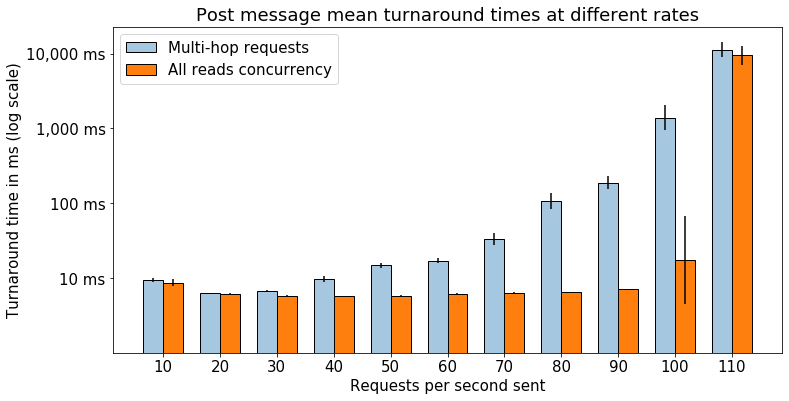

In [107]:
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(12, 6))
magic([1588520606558, 1588522191956], 
      ['Multi-hop requests', 'All reads concurrency'], 
      'multihop_vs_concurreads.png')

All reads concurrency-10-0.9363828157565396-0.045756331012731744
All reads concurrency-20-0.7872158559685422-0.012786316583682518
All reads concurrency-30-0.7543339783190669-0.012771560303858764
All reads concurrency-40-0.7550036119384061-0.005660684075111316
All reads concurrency-50-0.7605361772646146-0.0061536884657970485
All reads concurrency-60-0.7818099312877936-0.013725825239829402
All reads concurrency-70-0.8030612747715162-0.005207941167138575
All reads concurrency-80-0.8119538885424139-0.007435089336343016
All reads concurrency-90-0.8537986928852638-0.004616053090224931
All reads concurrency-100-1.2470494329027642-0.5889504357031432
All reads concurrency-110-3.9805658771001093-0.12628139268158786
SD-request-only concurrency-10-1.0222576621195325-0.04328706205833338
SD-request-only concurrency-20-0.8303506585130181-0.01690747772551066
SD-request-only concurrency-30-0.7848630338733246-0.00410248690722666
SD-request-only concurrency-40-0.7679469806237069-0.006088793896193849
SD-r

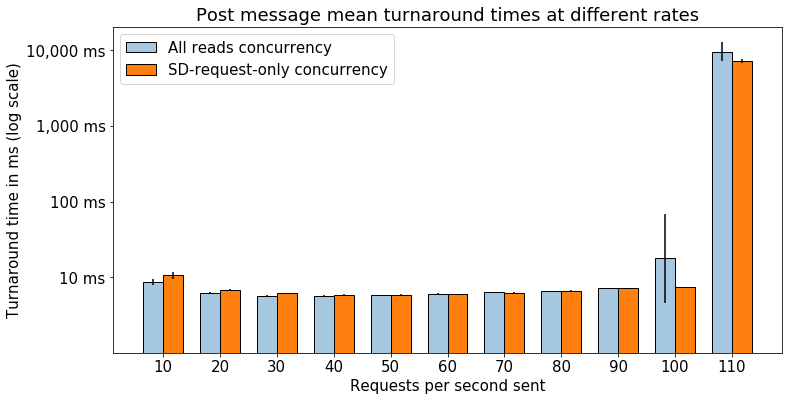

In [108]:
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(12, 6))
magic([1588522191956, 1588510006021], 
      ['All reads concurrency', 'SD-request-only concurrency'], 
      'concurreads_vs_sdconcurrency.png')

Multi-hop requests-10-0.9036647419321016-0.08934099988554152
Multi-hop requests-20-0.8325838210972933-0.016308380175899764
Multi-hop requests-30-0.8667056277049484-0.035862522921994336
Multi-hop requests-40-1.0039222414186615-0.05207510006706441
Multi-hop requests-50-1.2856104515030125-0.09003006445130879
Multi-hop requests-60-1.576225052497949-0.1763799537354567
Multi-hop requests-70-1.879717672497311-0.1668647954631204
Multi-hop requests-80-2.221848939884991-0.2552324849806033
Multi-hop requests-90-3.163319413508866-0.4774678627780279
Multi-hop requests-100-4.117981680148582-0.29008356646758643
Multi-hop requests-110-4.656564888292079-0.09564642340166099
SD request concurrency 1-10-0.888600721054061-0.07759069050176558
SD request concurrency 1-20-0.7654342439456928-0.01768031849011376
SD request concurrency 1-30-0.7588639740828799-0.009583382988031413
SD request concurrency 1-40-0.7507565676703948-0.00643628287962567
SD request concurrency 1-50-0.7826556845732122-0.016101580165847375

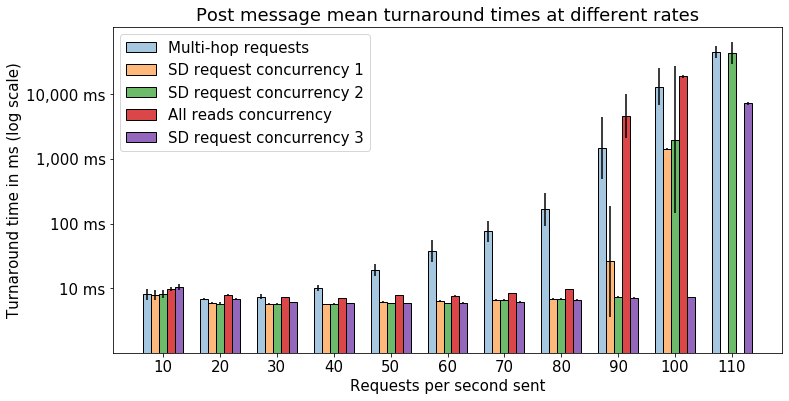

In [109]:
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(12, 6))
magic([1587916396441, 1587924832446, 1587929144235, 1587893442020, 1588510006021], 
      ['Multi-hop requests', 
       'SD request concurrency 1', 
       'SD request concurrency 2', 
       'All reads concurrency', 
       'SD request concurrency 3'])

Multi-hop requests-10-0.9974676267224276-0.012574766639884024
Multi-hop requests-20-0.9964777179410542-0.027300248812535396
Multi-hop requests-30-1.0908365177500297-0.02866082371053769
Multi-hop requests-40-1.363130918773063-0.04218234234960347
Multi-hop requests-50-1.5158494637622122-0.021580376628582455
Multi-hop requests-60-1.6017654887781776-0.033919061659276405
Multi-hop requests-70-1.8301751727285291-0.047635274414534336
Multi-hop requests-80-2.174893432831028-0.06430312873797733
Multi-hop requests-90-2.3957738536591644-0.07159204214744833
Multi-hop requests-100-3.17887066431825-0.15771110045713077
Multi-hop requests-110-4.061093349869973-0.10086542573819188
All reads concurrency-10-0.936613410536001-0.03625618111509865
All reads concurrency-20-0.9989810695004759-0.022610112249199035
All reads concurrency-30-1.1232378304061728-0.019094779001762627
All reads concurrency-40-1.393827704380578-0.03824682096108999
All reads concurrency-50-1.4900646868375003-0.03574808326330713
All rea

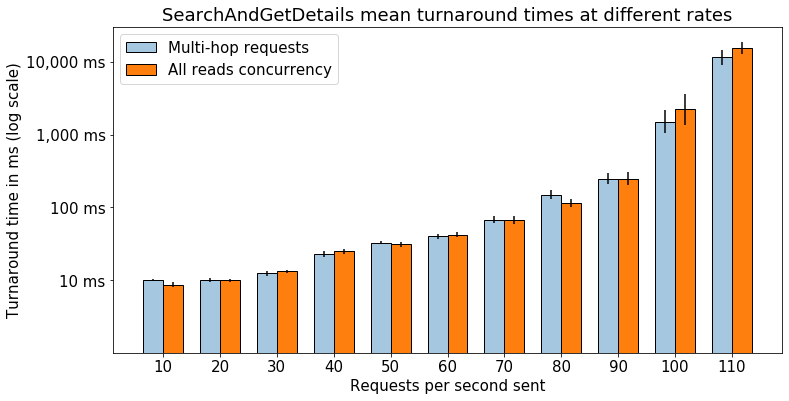

In [110]:
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(12, 6))
magic([1588520606558, 1588522191956], 
      ['Multi-hop requests', 'All reads concurrency'],
      'multihop_vs_concurreads_sds.png', 'psql.RequestSearchAndGetDetails', 'SearchAndGetDetails')

Simple OLEP-10-0.5981182174159774-0.06031284726229282
Simple OLEP-20-0.4330298451330637-0.010418836707262109
Simple OLEP-30-0.41733279048276245-0.016784189249479487
Simple OLEP-40-0.41455569182828356-0.005279084808059168
Simple OLEP-50-0.4007727441566693-0.009423643460659359
Simple OLEP-60-0.37603972639734307-0.01813304730103302
Simple OLEP-70-0.39999176087603916-0.027609821553710202
Simple OLEP-80-0.38870475336355165-0.005989020617822183
Simple OLEP-90-0.4118369656357008-0.006856622402593355
Simple OLEP-100-0.424996642013375-0.01864763915866382
Simple OLEP-110-0.40411669738869266-0.009618527133575552
Serialize-everything-10-0.9452542145391363-0.0745058238315719
Serialize-everything-20-0.9430281347963397-0.02245380916405077
Serialize-everything-30-1.1631773411275177-0.026993351660890393
Serialize-everything-40-1.4172132901567405-0.027144927881718735
Serialize-everything-50-1.6219832785340111-0.05396021772876252
Serialize-everything-60-1.802274196701978-0.06749601324334133
Serialize-eve

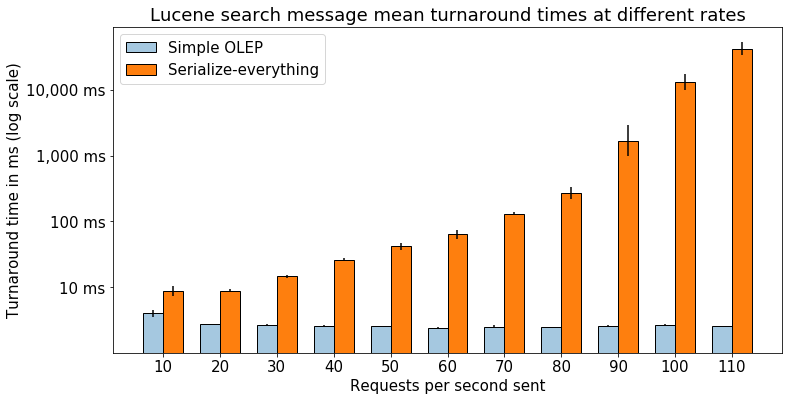

In [111]:
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(12, 6))
magic([1588527019868, 1588524756412],
      ['Simple OLEP', 'Serialize-everything'],
      'simpleolep_vs_serreads_lucene_searches.png', 'lucene.RequestSearchMessage', 'Lucene search message')

Simple OLEP-10-1.8769379646126307-0.017047706395671828
Simple OLEP-20-1.841317703331665-0.0030716647580187792
Simple OLEP-30-1.8824041108071876-0.011602385631336927
Simple OLEP-40-1.92378406120404-0.01291494724010555
Simple OLEP-50-1.9977035386869257-0.026219556787209622
Simple OLEP-60-2.0659915254024313-0.020217377898870962
Simple OLEP-70-2.2429450501114925-0.030817445802164965
Simple OLEP-80-2.5057169519500957-0.07699389719672754
Simple OLEP-90-3.1086866800744577-0.18709847343606503
Simple OLEP-100-3.955013287068576-0.1307429854659077
Simple OLEP-110-4.479406900957449-0.051724331520170544
Serialize-everything-10-1.8666314996920104-0.016699629268459325
Serialize-everything-20-1.819278792058778-0.0030444621347846487
Serialize-everything-30-1.8665572867212656-0.006797905849758149
Serialize-everything-40-1.921505948981091-0.014039365750433963
Serialize-everything-50-2.008030398761441-0.030641769093230135
Serialize-everything-60-2.0888696416494503-0.03066647871622392
Serialize-everything-

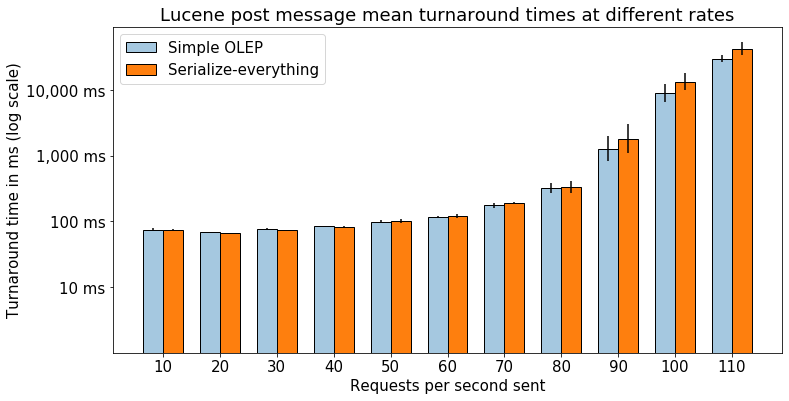

In [112]:
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(12, 6))
magic([1588527019868, 1588524756412],
      ['Simple OLEP', 'Serialize-everything'],
      'simpleolep_vs_serreads_lucene_posts.png', 'lucene.RequestPostMessage', 'Lucene post message')

RequestPostMessage 61.95456847902685
RequestDeleteConversation 5.491568645973154
RequestSearchMessage 2.022408244761106
RequestPostMessage 4.426934607382551
RequestDeleteConversation 0.7641694135906041
RequestConvoMessages 0.714070437080537
RequestMessageDetails 0.7317695775356245


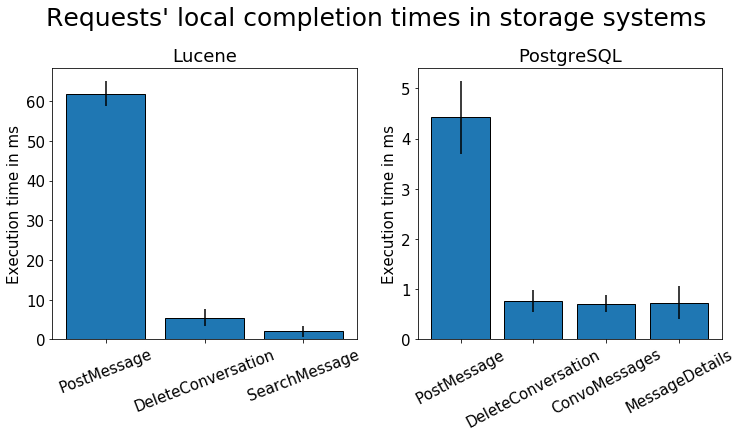

In [114]:
def plot_simple_request_times(ax, timestamp, storage_system, ss_name, requests, labels=None):
    base_alpha=0.3
    ofs = 50
    rsize = len(requests)
    
    for request, i in zip(requests, range(rsize)):
        csv = get_csv(timestamp, f'{storage_system}.total-time.{request}.hist')
        means = csv['mean'].values[ofs:]
        
        mean = np.mean(means)
        std = np.std(means)
        
        print(request, mean)
        
        ax.bar([i], [mean], yerr=std, color=[get_color(0, 1)],
                linewidth=1, edgecolor='black')
    
    if labels is None:
        labels = map(lambda s: s[7:], requests)
    
    ax.set_title(ss_name)
    ax.set_xticks(np.arange(rsize))
    ax.set_xticklabels(labels, rotation=7 * rsize)
    
    ax.set_ylabel('Execution time in ms')
#     ax.show()

matplotlib.rcParams['font.size'] = "15"
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plot_simple_request_times(axs[0], 1588086690771, 'lucene', 'Lucene', ['RequestPostMessage', 
                                                    'RequestDeleteConversation', 
                                                    'RequestSearchMessage'])

plot_simple_request_times(axs[1], 1588086690771, 'psql', 'PostgreSQL', ['RequestPostMessage', 
                                                    'RequestDeleteConversation', 
                                                    'RequestConvoMessages', 'RequestMessageDetails'])

fig.suptitle('Requests\' local completion times in storage systems', y=1.05, fontsize=25)
fig.savefig('ss_simple_times.png', pad_inches=0.35, bbox_inches='tight', dpi=250)

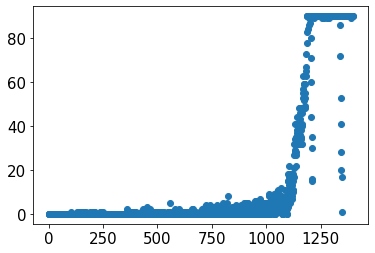

In [129]:
plt.scatter(np.arange(1399), get_csv(1588522191956, 'psql.opened-snapshots')['count'])

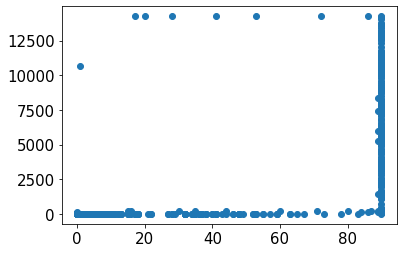

In [133]:
plt.scatter(get_csv(1588522191956, 'psql.opened-snapshots')['count'][:-1-50], get_csv(1588522191956, 'favours.psql.RequestPostMessage.hist')['mean'][:-50])

(array([108.,   1.,   0.,   2.,   0.,   7.,   1.,   1.,   1.,   9.]),
 array([  7.079978 ,  29.1641096,  51.2482412,  73.3323728,  95.4165044,
        117.500636 , 139.5847676, 161.6688992, 183.7530308, 205.8371624,
        227.921294 ]),
 <a list of 10 Patch objects>)

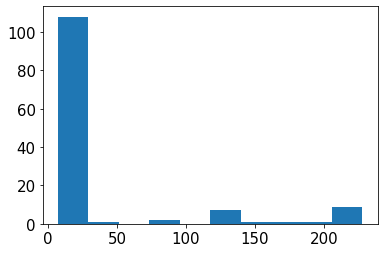

In [138]:
vals = get_csv(1588522191956, 'favours.psql.RequestPostMessage.hist')['mean'].values
rates = get_csv(1588522191956, 'polyglotAPI.controlledRate')['value'].values

idx = rates == 100

plt.hist(vals[idx])